In [ ]:
# !pip install setuptools==61.0.0 pyts mlflow plum-dispatch==1.7.2 torchdiffeq
# !pip install git+https://github.com/pnnl/neuromancer.git@master --ignore-requires-python --no-deps
# Uncomment pip installs for Colab notebook    

# Control 

## Typical scenario. Off policy control learning

In a typical real world control setting, due to cost and operational concerns, there is not an opportunity to directly interact with the system to learn a controller. In this scenario, the system is perturbed for some amount of time to collect measurements representative of the system state space, system identification is performed, and a controller is created based on the fitted model created via system identification. In the following cells we walk through the three stage process of generating data, system identification, and control policy learning using neuromancer. 

## Generate a representative of system behavior

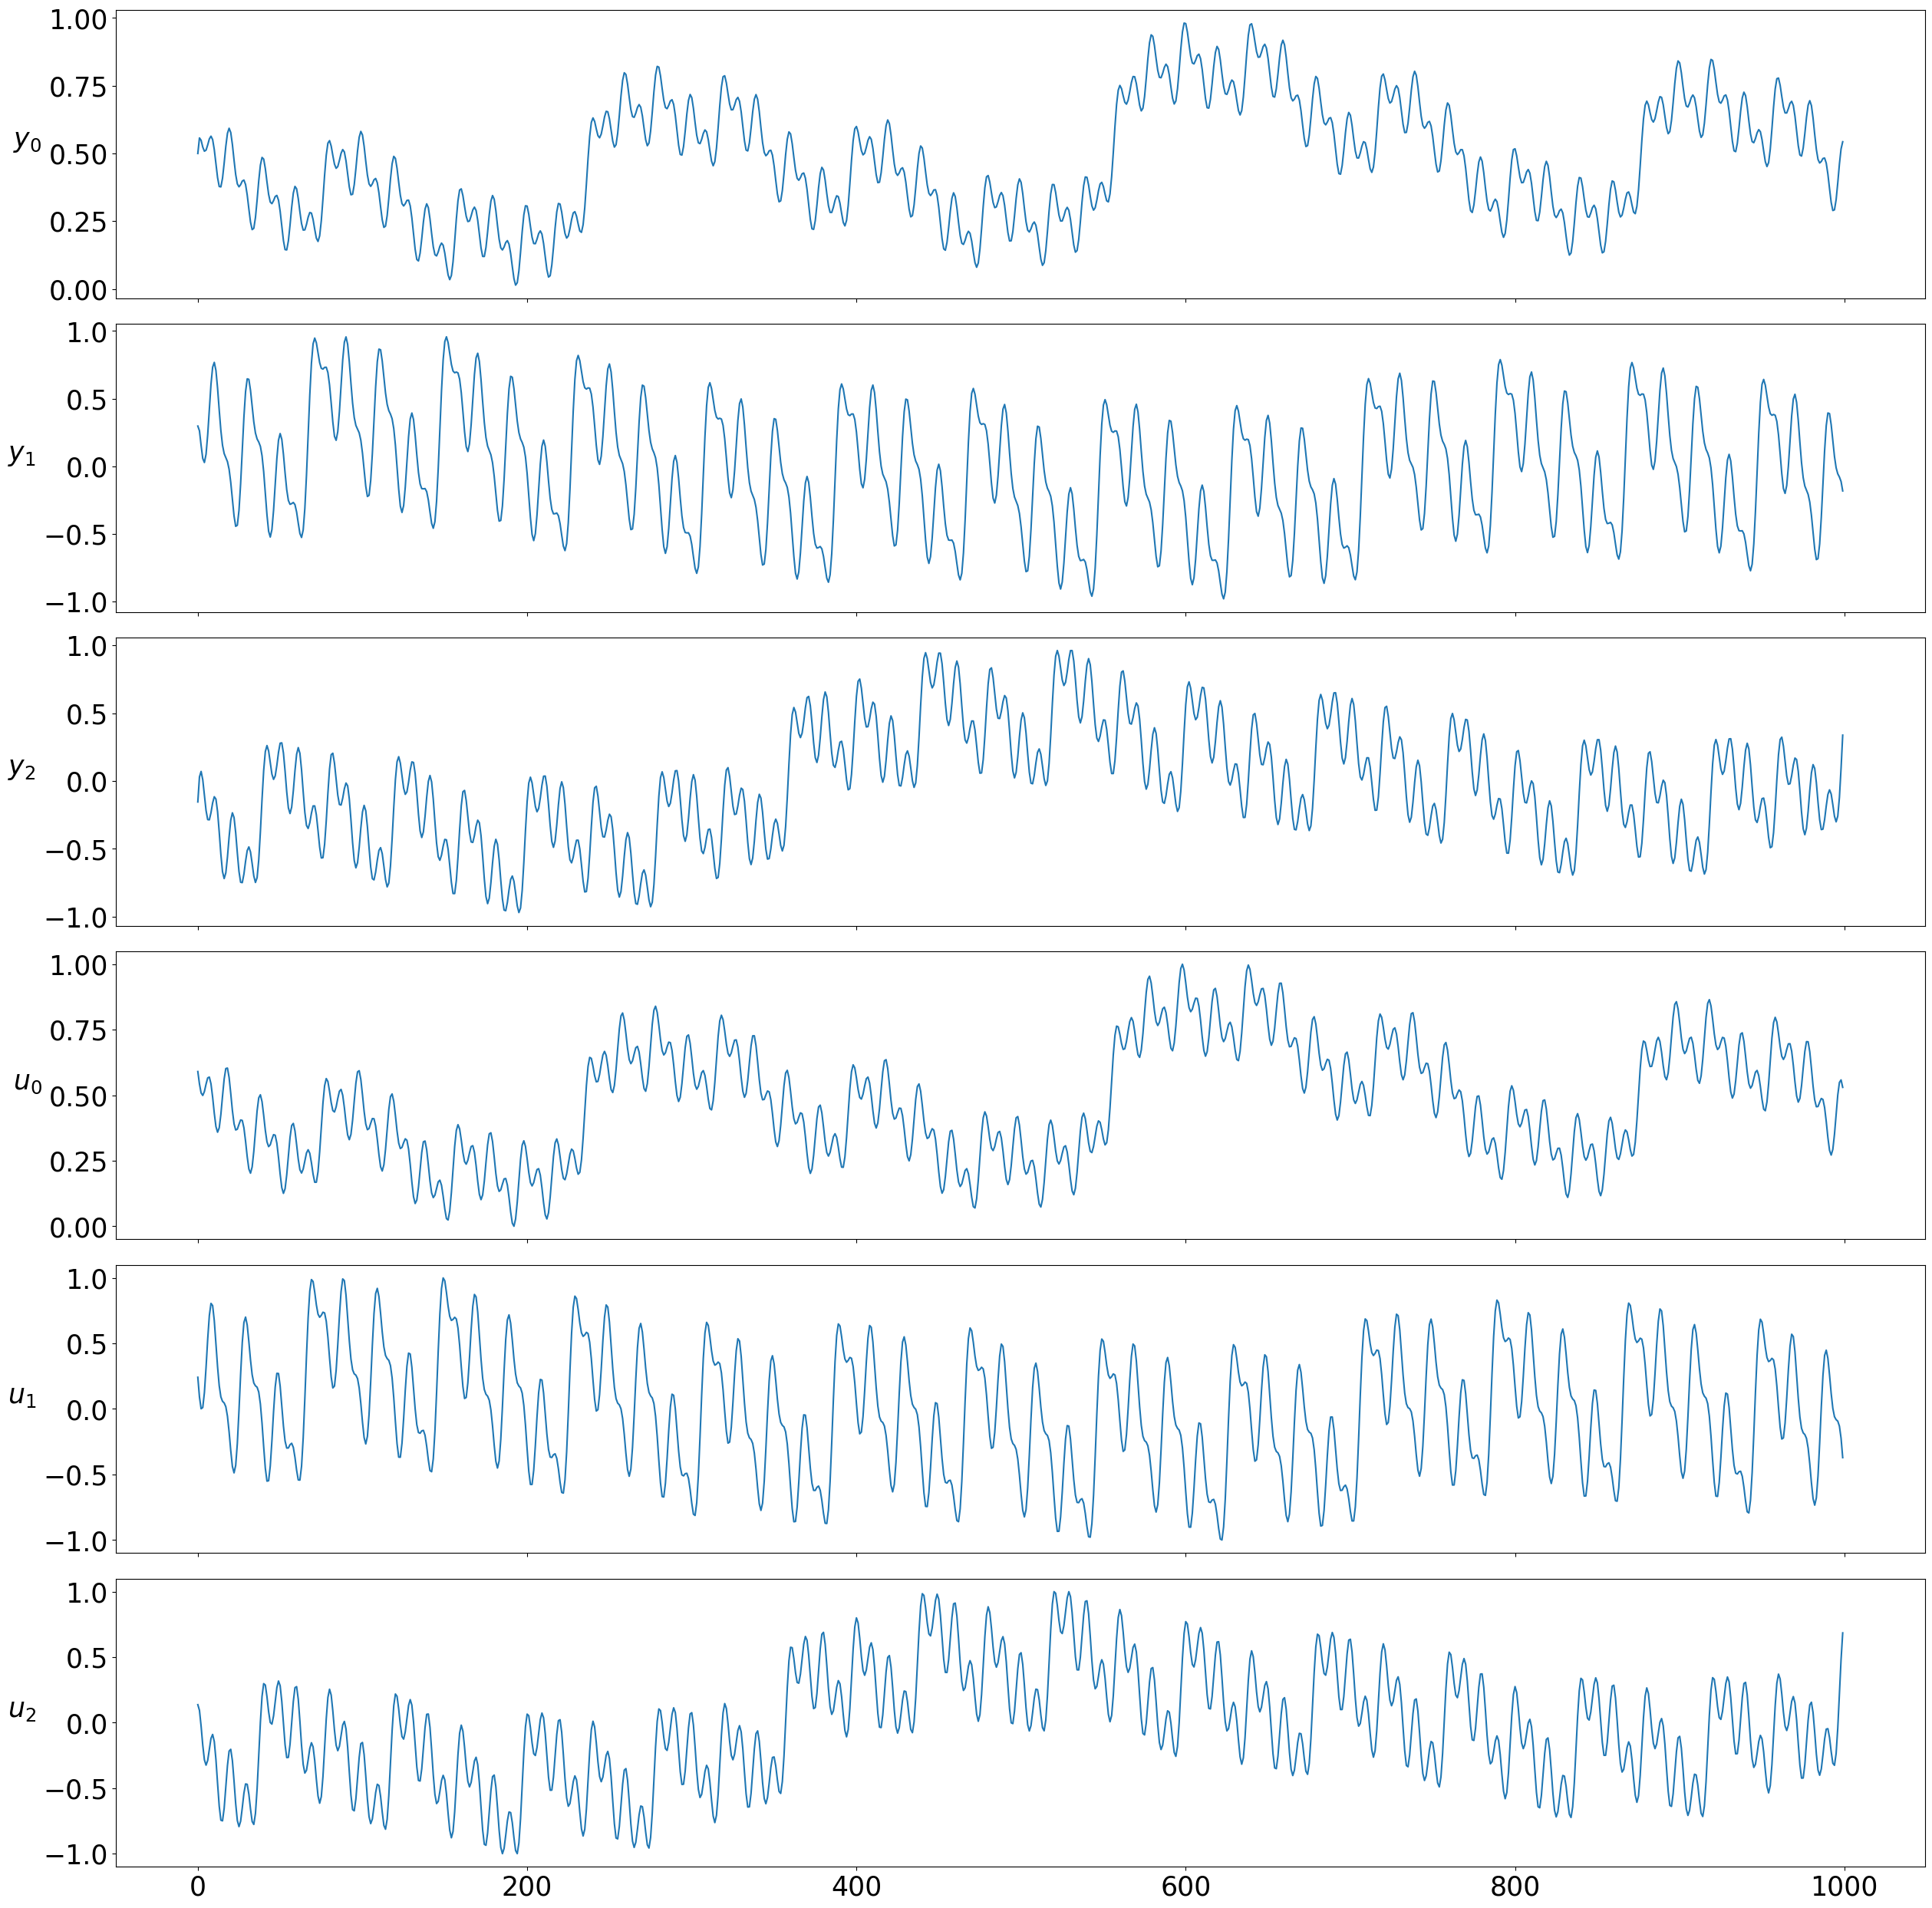

In [4]:
from neuromancer.psl.nonautonomous import Actuator
from neuromancer.dataset import DictDataset
sys = Actuator()

train_data, dev_data, test_data = [sys.simulate(nsim=1000) for i in range(3)]
sys.show(train_data)

from torch.utils.data import DataLoader
train_data, dev_data, test_data = [sys.normalize(d) for d in [train_data, dev_data, test_data]]
for d in [train_data, dev_data]:
    d['X'] = d['X'].reshape(100, 10, 3)
    d['U'] = d['U'].reshape(100, 10, 3)
    d['Y'] = d['Y'].reshape(100, 10, 3)
    d['xn'] = d['X'][:, 0:1, :]
    d['Time'] = d['Time'].reshape(100, -1)
train_dataset, dev_dataset, = [DictDataset(d, name=n) for d, n in zip([train_data, dev_data], ['train', 'dev'])]
train_loader, dev_loader, test_loader = [DataLoader(d, batch_size=100, collate_fn=d.collate_fn, shuffle=True) for d in [train_dataset, dev_dataset, dev_dataset]]


# Define a simple neural ODE model of the system

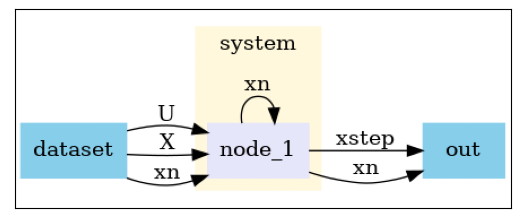

In [5]:
from neuromancer.system import MultipleShootingEuler, Node, System
integrator = MultipleShootingEuler(sys.nx, sys.nu, 20, 3, 0.1)
system_node = Node(integrator, ['X', 'xn', 'U'], ['xstep', 'xn'])
model = System([system_node])
model.show()

# Define the optimization problem

In [6]:
from neuromancer.constraint import variable
from neuromancer.problem import Problem
from neuromancer.loss import PenaltyLoss

# Nstep rollout predictions from the model
xNpred = variable('xn')[:, :-1, :]
# Single step rolllout predictions from the model
x1pred = variable('xstep')
# Ground truth data
xtrue = variable('X')

lossN = (xNpred == xtrue) ^ 2
lossN.update_name('lossN')

loss1 = (x1pred == xtrue) ^ 2
loss1.update_name('loss1')

obj = PenaltyLoss([lossN, loss1], [])
problem = Problem([model], obj)

## Minimize the system identification problem

In [7]:
from neuromancer.trainer import Trainer
import torch.optim as optim

opt = optim.Adam(model.parameters(), 0.001)
trainer = Trainer(problem, train_loader, dev_loader, test_loader, opt,
                  epochs=1000,
                  patience=300,
                  train_metric='train_loss',
                  dev_metric='dev_loss',
                  test_metric='test_loss',
                  eval_metric='dev_lossN')
best_model = trainer.train()

epoch: 0  train_loss: 0.4772954285144806
epoch: 1  train_loss: 0.4722791910171509
epoch: 2  train_loss: 0.46735861897468567
epoch: 3  train_loss: 0.46253126859664917
epoch: 4  train_loss: 0.45779484510421753
epoch: 5  train_loss: 0.45314764976501465
epoch: 6  train_loss: 0.44858813285827637
epoch: 7  train_loss: 0.44411444664001465
epoch: 8  train_loss: 0.4397240877151489
epoch: 9  train_loss: 0.43541470170021057
epoch: 10  train_loss: 0.43118396401405334
epoch: 11  train_loss: 0.427029013633728
epoch: 12  train_loss: 0.4229470193386078
epoch: 13  train_loss: 0.41893571615219116
epoch: 14  train_loss: 0.4149931073188782
epoch: 15  train_loss: 0.4111171364784241
epoch: 16  train_loss: 0.4073061943054199
epoch: 17  train_loss: 0.40355920791625977
epoch: 18  train_loss: 0.3998749554157257
epoch: 19  train_loss: 0.39625295996665955
epoch: 20  train_loss: 0.3926927447319031
epoch: 21  train_loss: 0.3891945779323578
epoch: 22  train_loss: 0.38575854897499084
epoch: 23  train_loss: 0.38238528

epoch: 194  train_loss: 0.0717136487364769
epoch: 195  train_loss: 0.07118168473243713
epoch: 196  train_loss: 0.0706607848405838
epoch: 197  train_loss: 0.07015079259872437
epoch: 198  train_loss: 0.06965161114931107
epoch: 199  train_loss: 0.06916305422782898
epoch: 200  train_loss: 0.06868495047092438
epoch: 201  train_loss: 0.06821711361408234
epoch: 202  train_loss: 0.06775932013988495
epoch: 203  train_loss: 0.06731138378381729
epoch: 204  train_loss: 0.06687302142381668
epoch: 205  train_loss: 0.06644400954246521
epoch: 206  train_loss: 0.06602407246828079
epoch: 207  train_loss: 0.06561291962862015
epoch: 208  train_loss: 0.06521028280258179
epoch: 209  train_loss: 0.06481585651636124
epoch: 210  train_loss: 0.06442933529615402
epoch: 211  train_loss: 0.06405040621757507
epoch: 212  train_loss: 0.06367876380681992
epoch: 213  train_loss: 0.06331408023834229
epoch: 214  train_loss: 0.0629560649394989
epoch: 215  train_loss: 0.0626043826341629
epoch: 216  train_loss: 0.0622587502

epoch: 384  train_loss: 0.042588185518980026
epoch: 385  train_loss: 0.04258033633232117
epoch: 386  train_loss: 0.042572587728500366
epoch: 387  train_loss: 0.042564939707517624
epoch: 388  train_loss: 0.042557377368211746
epoch: 389  train_loss: 0.04254990443587303
epoch: 390  train_loss: 0.04254251718521118
epoch: 391  train_loss: 0.042535215616226196
epoch: 392  train_loss: 0.04252798855304718
epoch: 393  train_loss: 0.04252083599567413
epoch: 394  train_loss: 0.04251375421881676
epoch: 395  train_loss: 0.042506735771894455
epoch: 396  train_loss: 0.04249979555606842
epoch: 397  train_loss: 0.042492903769016266
epoch: 398  train_loss: 0.042486079037189484
epoch: 399  train_loss: 0.04247931391000748
epoch: 400  train_loss: 0.04247260093688965
epoch: 401  train_loss: 0.0424659438431263
epoch: 402  train_loss: 0.04245933145284653
epoch: 403  train_loss: 0.042452771216630936
epoch: 404  train_loss: 0.042446259409189224
epoch: 405  train_loss: 0.042439788579940796
epoch: 406  train_loss

epoch: 575  train_loss: 0.041540373116731644
epoch: 576  train_loss: 0.041535504162311554
epoch: 577  train_loss: 0.041530635207891464
epoch: 578  train_loss: 0.04152576997876167
epoch: 579  train_loss: 0.04152090847492218
epoch: 580  train_loss: 0.041516050696372986
epoch: 581  train_loss: 0.04151118919253349
epoch: 582  train_loss: 0.0415063351392746
epoch: 583  train_loss: 0.0415014810860157
epoch: 584  train_loss: 0.0414966344833374
epoch: 585  train_loss: 0.0414917878806591
epoch: 586  train_loss: 0.0414869450032711
epoch: 587  train_loss: 0.0414821058511734
epoch: 588  train_loss: 0.0414772629737854
epoch: 589  train_loss: 0.041472427546978
epoch: 590  train_loss: 0.04146759212017059
epoch: 591  train_loss: 0.04146276041865349
epoch: 592  train_loss: 0.04145793616771698
epoch: 593  train_loss: 0.04145310819149017
epoch: 594  train_loss: 0.041448287665843964
epoch: 595  train_loss: 0.041443463414907455
epoch: 596  train_loss: 0.041438646614551544
epoch: 597  train_loss: 0.04143383

epoch: 765  train_loss: 0.04063695669174194
epoch: 766  train_loss: 0.040632136166095734
epoch: 767  train_loss: 0.04062732681632042
epoch: 768  train_loss: 0.04062251001596451
epoch: 769  train_loss: 0.0406176932156086
epoch: 770  train_loss: 0.040612876415252686
epoch: 771  train_loss: 0.04060805216431618
epoch: 772  train_loss: 0.04060322791337967
epoch: 773  train_loss: 0.04059840738773346
epoch: 774  train_loss: 0.040593575686216354
epoch: 775  train_loss: 0.04058874770998955
epoch: 776  train_loss: 0.04058391973376274
epoch: 777  train_loss: 0.04057908430695534
epoch: 778  train_loss: 0.04057425260543823
epoch: 779  train_loss: 0.04056940972805023
epoch: 780  train_loss: 0.04056457802653313
epoch: 781  train_loss: 0.04055973142385483
epoch: 782  train_loss: 0.04055488482117653
epoch: 783  train_loss: 0.04055004194378853
epoch: 784  train_loss: 0.04054519161581993
epoch: 785  train_loss: 0.040540341287851334
epoch: 786  train_loss: 0.040535490959882736
epoch: 787  train_loss: 0.04

epoch: 951  train_loss: 0.039705805480480194
epoch: 952  train_loss: 0.03970056399703026
epoch: 953  train_loss: 0.039695318788290024
epoch: 954  train_loss: 0.039690062403678894
epoch: 955  train_loss: 0.039684806019067764
epoch: 956  train_loss: 0.039679545909166336
epoch: 957  train_loss: 0.03967427834868431
epoch: 958  train_loss: 0.039669010788202286
epoch: 959  train_loss: 0.039663735777139664
epoch: 960  train_loss: 0.039658453315496445
epoch: 961  train_loss: 0.03965316712856293
epoch: 962  train_loss: 0.03964788094162941
epoch: 963  train_loss: 0.039642587304115295
epoch: 964  train_loss: 0.039637286216020584
epoch: 965  train_loss: 0.039631981402635574
epoch: 966  train_loss: 0.039626672863960266
epoch: 967  train_loss: 0.03962135687470436
epoch: 968  train_loss: 0.039616040885448456
epoch: 969  train_loss: 0.039610717445611954
epoch: 970  train_loss: 0.039605382829904556
epoch: 971  train_loss: 0.03960005193948746
epoch: 972  train_loss: 0.03959470987319946
epoch: 973  train

## Evaluate system model on 1000 time step rollout

{'Y': (1000, 3), 'X': (1000, 3), 'U': (1000, 3), 'Time': (1000,)}


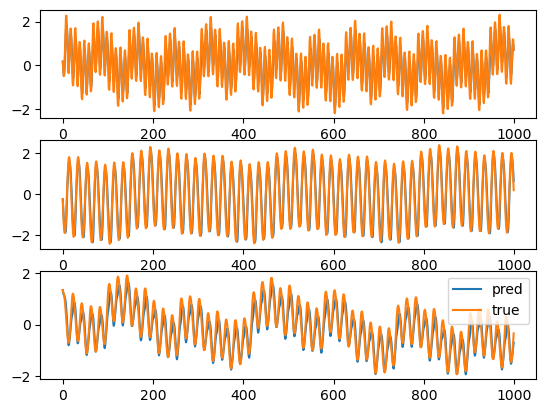

In [9]:
import torch
test_data = sys.normalize(sys.simulate(nsim=1000))
print({k: v.shape for k, v in test_data.items()})

test_data['X'] = test_data['X'].reshape(1, *test_data['X'].shape)
test_data['U'] = test_data['U'].reshape(1, *test_data['U'].shape)
test_data['xn'] = test_data['X'][:, 0:1, :]
test_data = {k: torch.tensor(v, dtype=torch.float32) for k, v in test_data.items()}
test_output = model(test_data)

import matplotlib.pyplot as plt
fix, ax = plt.subplots(nrows=3)
for v in range(3):
    ax[v].plot(test_output['xn'][0, :-1, v].detach().numpy(), label='pred')
    ax[v].plot(test_data['X'][0, :, v].detach().numpy(), label='true')
plt.legend()

## Create a closed loop system using the system model and a parametrized control policy


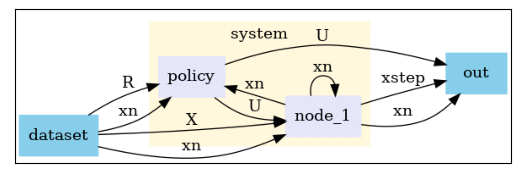

In [10]:
nx, nu = sys.nx, sys.nu
from neuromancer import blocks


class Policy(torch.nn.Module):

    def __init__(self, insize, outsize):
        super().__init__()
        self.net = blocks.MLP(insize, outsize, bias=True, hsizes=[20, 20, 20])

    def forward(self, x, R):
        features = torch.cat([x, R], dim=-1)
        return self.net(features)

insize = 2*nx
policy = Policy(insize, nu)
policy_node = Node(policy, ['xn', 'R'], ['U'], name='policy')
cl_system = System([policy_node, system_node])
cl_system.show()

## Optimizing the control policy

For this simple Actuator system the same dataset can be used for learning a control policy as we used to learn the system model. Here we wish to optimize  controlling the system to some reference trajectory R.

In [12]:
train_dataset = DictDataset({'R': train_data['X'], 'X': train_data['X'], 'xn': train_data['xn']}, name='train')
dev_dataset = DictDataset({'R': dev_data['X'], 'X': train_data['X'], 'xn': dev_data['xn']}, name='dev')
train_loader, dev_loader = [DataLoader(d, batch_size=100, collate_fn=d.collate_fn, shuffle=True) for d in [train_dataset, dev_dataset]]

In [13]:
opt = optim.Adam(policy.parameters(), 0.01)

tru = variable('xn')[:, 1:, :]
ref = variable('R')
u = variable('U')
loss = (ref == tru) ^ 2
loss.update_name('loss')

obj = PenaltyLoss([loss], [])
problem = Problem([cl_system], obj)

logout = ['loss']
trainer = Trainer(problem, train_loader, dev_loader, dev_loader, opt,
                  epochs=1000,
                  patience=1000,
                  train_metric='train_loss',
                  dev_metric='dev_loss',
                  test_metric='dev_loss',
                  eval_metric='dev_loss')

best_model = trainer.train()
trainer.model.load_state_dict(best_model)

epoch: 0  train_loss: 0.9010558128356934
epoch: 1  train_loss: 0.7592136263847351
epoch: 2  train_loss: 0.6337012648582458
epoch: 3  train_loss: 0.5127937197685242
epoch: 4  train_loss: 0.39192235469818115
epoch: 5  train_loss: 0.2844519317150116
epoch: 6  train_loss: 0.2345295548439026
epoch: 7  train_loss: 0.19212593138217926
epoch: 8  train_loss: 0.13312092423439026
epoch: 9  train_loss: 0.12816153466701508
epoch: 10  train_loss: 0.1273716390132904
epoch: 11  train_loss: 0.09740979969501495
epoch: 12  train_loss: 0.0755225270986557
epoch: 13  train_loss: 0.06829584389925003
epoch: 14  train_loss: 0.06543360650539398
epoch: 15  train_loss: 0.061063699424266815
epoch: 16  train_loss: 0.0556669682264328
epoch: 17  train_loss: 0.051801905035972595
epoch: 18  train_loss: 0.0503794364631176
epoch: 19  train_loss: 0.0492805577814579
epoch: 20  train_loss: 0.04545893520116806
epoch: 21  train_loss: 0.03858037292957306
epoch: 22  train_loss: 0.0315236859023571
epoch: 23  train_loss: 0.027310

epoch: 196  train_loss: 0.000978937023319304
epoch: 197  train_loss: 0.0009785741567611694
epoch: 198  train_loss: 0.0009782373672351241
epoch: 199  train_loss: 0.0009779250249266624
epoch: 200  train_loss: 0.0009776355000212789
epoch: 201  train_loss: 0.0009773665806278586
epoch: 202  train_loss: 0.0009771175682544708
epoch: 203  train_loss: 0.0009768869495019317
epoch: 204  train_loss: 0.0009766730945557356
epoch: 205  train_loss: 0.0009764752467162907
epoch: 206  train_loss: 0.0009762921254150569
epoch: 207  train_loss: 0.000976122566498816
epoch: 208  train_loss: 0.0009759653476066887
epoch: 209  train_loss: 0.0009758201194927096
epoch: 210  train_loss: 0.0009756857762113214
epoch: 211  train_loss: 0.0009755614446476102
epoch: 212  train_loss: 0.0009754464845173061
epoch: 213  train_loss: 0.0009753405465744436
epoch: 214  train_loss: 0.0009752422920428216
epoch: 215  train_loss: 0.0009751517209224403
epoch: 216  train_loss: 0.0009750679600983858
epoch: 217  train_loss: 0.0009749906

epoch: 378  train_loss: 0.0009741098037920892
epoch: 379  train_loss: 0.0009741098037920892
epoch: 380  train_loss: 0.0009741098037920892
epoch: 381  train_loss: 0.0009741098037920892
epoch: 382  train_loss: 0.0009741096291691065
epoch: 383  train_loss: 0.0009741098037920892
epoch: 384  train_loss: 0.0009741098037920892
epoch: 385  train_loss: 0.0009741098619997501
epoch: 386  train_loss: 0.0009741098037920892
epoch: 387  train_loss: 0.0009741098037920892
epoch: 388  train_loss: 0.0009741098037920892
epoch: 389  train_loss: 0.0009741098037920892
epoch: 390  train_loss: 0.0009741098037920892
epoch: 391  train_loss: 0.0009741097455844283
epoch: 392  train_loss: 0.0009741098619997501
epoch: 393  train_loss: 0.0009741097455844283
epoch: 394  train_loss: 0.0009741098037920892
epoch: 395  train_loss: 0.0009741096291691065
epoch: 396  train_loss: 0.0009741097455844283
epoch: 397  train_loss: 0.0009741098037920892
epoch: 398  train_loss: 0.0009741098037920892
epoch: 399  train_loss: 0.00097410

epoch: 573  train_loss: 0.0009741098037920892
epoch: 574  train_loss: 0.0009741097455844283
epoch: 575  train_loss: 0.0009741098037920892
epoch: 576  train_loss: 0.0009741096291691065
epoch: 577  train_loss: 0.0009741096291691065
epoch: 578  train_loss: 0.0009741098037920892
epoch: 579  train_loss: 0.0009741098037920892
epoch: 580  train_loss: 0.0009741097455844283
epoch: 581  train_loss: 0.0009741098037920892
epoch: 582  train_loss: 0.0009741096291691065
epoch: 583  train_loss: 0.0009741097455844283
epoch: 584  train_loss: 0.0009741098037920892
epoch: 585  train_loss: 0.0009741097455844283
epoch: 586  train_loss: 0.0009741097455844283
epoch: 587  train_loss: 0.0009741097455844283
epoch: 588  train_loss: 0.0009741096291691065
epoch: 589  train_loss: 0.0009741098037920892
epoch: 590  train_loss: 0.0009741096291691065
epoch: 591  train_loss: 0.0009741095709614456
epoch: 592  train_loss: 0.0009741098037920892
epoch: 593  train_loss: 0.0009741098037920892
epoch: 594  train_loss: 0.00097410

epoch: 767  train_loss: 0.0009741096291691065
epoch: 768  train_loss: 0.0009741096291691065
epoch: 769  train_loss: 0.0009741096291691065
epoch: 770  train_loss: 0.0009741096291691065
epoch: 771  train_loss: 0.0009741098037920892
epoch: 772  train_loss: 0.0009741097455844283
epoch: 773  train_loss: 0.0009741096291691065
epoch: 774  train_loss: 0.0009741097455844283
epoch: 775  train_loss: 0.0009741098037920892
epoch: 776  train_loss: 0.0009741098619997501
epoch: 777  train_loss: 0.0009741098619997501
epoch: 778  train_loss: 0.0009741098619997501
epoch: 779  train_loss: 0.0009741097455844283
epoch: 780  train_loss: 0.0009741098037920892
epoch: 781  train_loss: 0.0009741096291691065
epoch: 782  train_loss: 0.0009741096291691065
epoch: 783  train_loss: 0.0009741096291691065
epoch: 784  train_loss: 0.0009741098037920892
epoch: 785  train_loss: 0.0009741098037920892
epoch: 786  train_loss: 0.0009741098037920892
epoch: 787  train_loss: 0.0009741098037920892
epoch: 788  train_loss: 0.00097410

epoch: 960  train_loss: 0.0009741098037920892
epoch: 961  train_loss: 0.0009741097455844283
epoch: 962  train_loss: 0.0009741098037920892
epoch: 963  train_loss: 0.0009741098619997501
epoch: 964  train_loss: 0.0009741098619997501
epoch: 965  train_loss: 0.0009741098619997501
epoch: 966  train_loss: 0.0009741098037920892
epoch: 967  train_loss: 0.0009741098037920892
epoch: 968  train_loss: 0.0009741098037920892
epoch: 969  train_loss: 0.0009741098037920892
epoch: 970  train_loss: 0.0009741097455844283
epoch: 971  train_loss: 0.0009741098619997501
epoch: 972  train_loss: 0.0009741098037920892
epoch: 973  train_loss: 0.0009741097455844283
epoch: 974  train_loss: 0.0009741098037920892
epoch: 975  train_loss: 0.0009741098037920892
epoch: 976  train_loss: 0.0009741096291691065
epoch: 977  train_loss: 0.0009741098037920892
epoch: 978  train_loss: 0.0009741098037920892
epoch: 979  train_loss: 0.0009741096291691065
epoch: 980  train_loss: 0.0009741097455844283
epoch: 981  train_loss: 0.00097410

<All keys matched successfully>

## Evaluating the model on the true system

With the optional pytorch backend for the original ODE system we can now swap out our learned model to evaluate the learned control policy on the original system. 

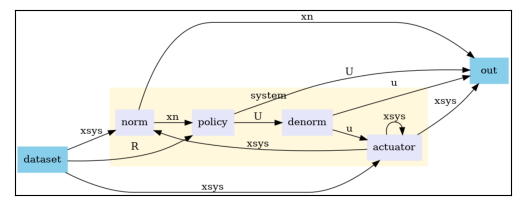

In [15]:
sys.change_backend('torch')
# We will have to denormalize the policy actions according to the system stats
# Conversely we will have to normalize the system states according to the system stats to hand to the policy

def norm(x):
    return sys.normalize(x, key='X')

def denorm(u):
    return sys.denormalize(u, key='U')

normnode = Node(norm, ['xsys'], ['xn'], name='norm')
denormnode = Node(denorm, ['U'], ['u'], name='denorm')
sysnode = Node(sys, ['xsys', 'u'], ['xsys'], name='actuator')
test_system = System([normnode, policy_node, denormnode, sysnode])
test_system.show()


## Evaluate on 1000 steps with a new reference trajectory distribution

{'R': torch.Size([1, 1000, 3]), 'xsys': torch.Size([1, 1, 3]), 'Time': (1, 1000, 1)}
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])


/home/tuor369/anaconda3/envs/nm/lib/python3.10/site-packages/torchdiffeq/_impl/misc.py:11: UserWarning: Dopri5Solver: Unexpected arguments {'grid_points': tensor([0.0000, 0.1000]), 'eps': 1e-06}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))
/mnt/c/Users/tuor369/gitland/neuromancer_main/neuromancer/src/neuromancer/psl/base.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.B.cast(method_output, dtype=self.B.core.float32)


torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([

torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([

torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([

torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([

torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([1, 3]) torch.Size([1, 3])
torch.Size([

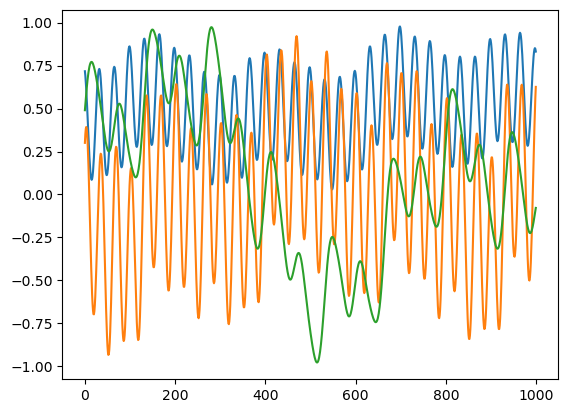

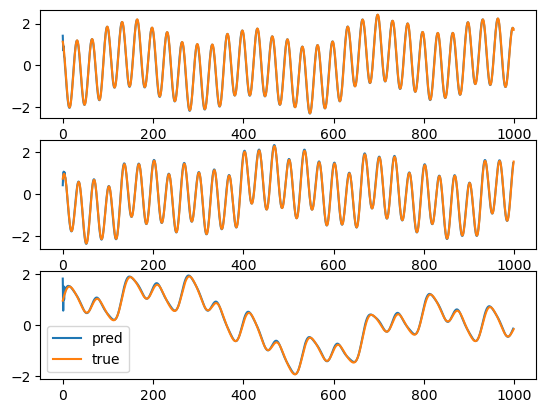

In [16]:
from neuromancer.psl.signals import sines
import numpy as np
references = sines(nsim=1000, d=sys.nx, min=sys.stats['X']['min'], max=sys.stats['X']['max'])
plt.plot(references)
test_data = {'R': torch.tensor(sys.normalize(references, key='X'), dtype=torch.float32).unsqueeze(0), 'xsys': sys.get_x0().reshape(1, 1, -1),
            'Time': (np.arange(1000)*sys.ts).reshape(1, 1000, 1)}
print({k: v.shape for k, v in test_data.items()})
test_system.nsteps=1000
with torch.no_grad():
    test_out = test_system(test_data)

print({k: v.shape for k, v in test_out.items()})
fix, ax = plt.subplots(nrows=3)
for v in range(3):
    ax[v].plot(test_out['xn'][0, 1:, v].detach().numpy(), label='pred')
    ax[v].plot(test_data['R'][0, :, v].detach().numpy(), label='true')
plt.legend()
plt.savefig('control.png')
